# Retrieve models, data, libraries etc.



In [2]:
!pip install seaborn

In [1]:
import os
import sys
import copy
import random
import json
import yaml
import glob
import cv2
import numpy as np
import time
import csv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
%matplotlib inline
import pandas as pd
import logging
import torch

# Set up logging
logging.basicConfig(level=logging.INFO)


In [6]:
DATA_DIR = "data_images"

In [7]:
def download_and_unzip(url, save_path, extract_dir):
    print("Downloading assets...")
    file = requests.get(url)

    open(save_path, "wb").write(file.content)
    print("Download completed.")

    try:
        if save_path.endswith(".zip"):
            with ZipFile(save_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print("Extraction Done")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_image(url):
    filename = os.path.basename(url)

    response = requests.get(url)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        file.write(response.content)

    return os.path.abspath(filename)

def get_basename(path):
  return os.path.basename(path)

def print_fish_data(fish_data):
    for idx, fish in enumerate(fish_data, start=1):
        print(f"ID: {idx}")
        print(f"Name: {fish['name']}")
        print(f"Species ID: {fish['species_id']}")
        print(f"Distance: {fish['distance']:.3f}")
        print(f"Accuracy: {fish['accuracy']:.2%}")
        print("-" * 40)


In [ ]:
# Links to models
MODEL_URLS = {
    'classification': 'https://storage.googleapis.com/fishial-ml-resources/classification_rectangle_v7-1.zip',
    'segmentation': 'https://storage.googleapis.com/fishial-ml-resources/segmentator_fpn_res18_416_1.zip',
    'detection': 'https://storage.googleapis.com/fishial-ml-resources/detector_v10_m3.zip',
}

# Model directories
MODEL_DIRS = {
    'classification': "models/classification",
    'segmentation': "models/segmentation",
    'detection': "models/detection",
}

# Create directories and download models
for model_name, url in MODEL_URLS.items():
    model_dir = MODEL_DIRS[model_name]
    zip_path = os.path.join(os.getcwd(), get_basename(url))

    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    download_and_unzip(url, zip_path, model_dir)  # Download and unzip the model

  # Remove the zip file after extraction
    try:
        os.remove(zip_path)
        logging.info(f"Removed zip file {zip_path}")
    except Exception as e:
        logging.error(f"Failed to remove zip file {zip_path}: {e}")

Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done


In [ ]:
from models.classification.inference import EmbeddingClassifier
from models.detection.inference import YOLOInference
from models.segmentation.inference import Inference

# Model initialization
classifier = EmbeddingClassifier(
    os.path.join(MODEL_DIRS['classification'], 'model.ts'),
    os.path.join(MODEL_DIRS['classification'], 'database.pt')
)

segmentator = Inference(
    model_path=os.path.join(MODEL_DIRS['segmentation'], 'model.ts'),
    image_size=416
)

detector = YOLOInference(
    os.path.join(MODEL_DIRS['detection'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.9,
    nms_threshold=0.3,
    yolo_ver='v10'
)


# Data preparation

In [ ]:
images_path = os.path.join(DATA_DIR, "timor_leste") # Images

fishial_path = os.path.join(DATA_DIR, "fishial_V7.csv") # Fishial's species for V7
timor_leste_data_path = os.path.join(DATA_DIR, "timor-leste.csv") # Annotation info for ground truth

In [ ]:
# Read species list (all species in Fishial's V7 database)
df_fishial = pd.read_csv(fishial_path, encoding="utf-8-sig", header=None, sep=";")
df_fishial = set(df_fishial[0].str.strip())

# Read annotation info (Timor-leste)
df_tl_ann = pd.read_csv(timor_leste_data_path, encoding="utf-8-sig", header=0, skiprows=1)
df_tl_ann = df_tl_ann[["image_file", "catch_name_en", "Species_name", "Family"]]

# Keep only valid rows (species in fishial list)
valid_rows = df_tl_ann[df_tl_ann["Species_name"].isin(df_fishial)]

# Filter for files that actually exist
existing_files = set(os.listdir(images_path))
valid_rows = valid_rows[valid_rows["image_file"].isin(existing_files)]

# Convert to list
file_names = valid_rows["image_file"].tolist()

print("Number of images:", len(df_tl_ann))
print("Number of images with valid species:", len(valid_rows))
print("Number of unique images:", len(set(file_names)))


Number of images: 603
Number of images with valid species: 160
Number of unique images: 143


# Classification



Processing: 1689120590238.jpg
--------------------------------------------------
ID: 1
Name: Seriola rivoliana
Species ID: c49ca4d4-2992-4a87-a9a6-480a645d2d1a
Distance: 0.162
Accuracy: 26.67%
----------------------------------------
ID: 2
Name: Trachinotus goodei
Species ID: d34b0077-bc1b-4d0d-8ef7-2a9f485f828f
Distance: 0.403
Accuracy: 20.00%
----------------------------------------
ID: 3
Name: Albula vulpes
Species ID: b10ece44-c112-4efb-af0f-be31b66b0cac
Distance: 0.108
Accuracy: 13.33%
----------------------------------------
ID: 4
Name: Merlangius merlangus
Species ID: 8020bc5a-00aa-4b7b-bf5f-9486efaf8a03
Distance: 0.310
Accuracy: 6.67%
----------------------------------------
ID: 5
Name: Trachinotus carolinus
Species ID: c9f93d8f-1d69-4306-b2d0-4405b2f47d45
Distance: 0.246
Accuracy: 6.67%
----------------------------------------
ID: 6
Name: Hampala macrolepidota
Species ID: 5cee1de2-4154-4934-a5f9-7edff7d59d15
Distance: 0.194
Accuracy: 6.67%
------------------------------------

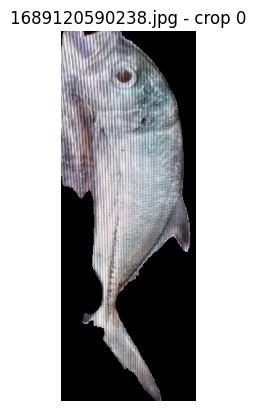

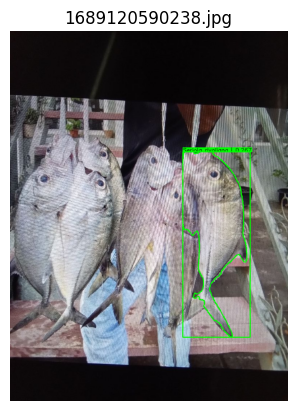


Processing: 1689577829534.jpg


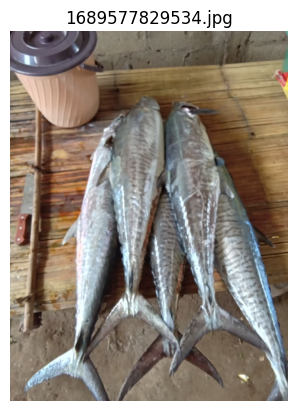


Processing: 1689577974563.jpg


KeyboardInterrupt: 

In [ ]:
for img_path in file_names:
    try:
        print("\n" + "=" * 60)
        print(f"Processing: {os.path.basename(img_path)}")

        fish_bgr_np = cv2.imread(os.path.join(DATA_DIR, "timor_leste", img_path))
        if fish_bgr_np is None:
            print("Could not read image, skipping.")
            continue

        visulize_img_bgr = fish_bgr_np.copy()
        visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
        visulize_img = copy.deepcopy(visulize_img_rgb)

        # OBJECT DETECTION
        boxes = detector.predict(visulize_img_rgb)[0]

        # Track if we created any mask preview for saving
        mask_idx = 0
        for box in boxes:
            cropped_fish_bgr = box.get_mask_BGR()
            cropped_fish_rgb = box.get_mask_RGB()

            # SEGMENTATION
            segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]
            cropped_fish_mask = segmented_polygons.mask_polygon(cropped_fish_rgb)

            # draw polygon on the full image
            segmented_polygons.move_to(box.x1, box.y1)
            segmented_polygons.draw_polygon(visulize_img)

            # CLASSIFICATION
            classification_result = classifier.batch_inference([cropped_fish_bgr])[0]
            label = (
                f"{classification_result[0]['name']} | {round(classification_result[0]['accuracy'], 3)}"
                if len(classification_result)
                else "Not Found"
            )

            box.draw_label(visulize_img, label)
            box.draw_box(visulize_img)

            # Show each cropped mask preview
            print("-" * 50)
            print_fish_data(classification_result)

            plt.figure()
            plt.imshow(cropped_fish_mask)
            plt.axis('off')
            plt.title(f"{os.path.basename(img_path)} - crop {mask_idx}")
            plt.show()

        # Show the final visualization for the image
        plt.figure()
        plt.imshow(visulize_img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
        plt.show()

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

In [ ]:
def norm(name):
    return os.path.basename(str(name)).strip().lower()

# A case-insensitive lookup of actual image file paths in timor-leste (handles subfolders + .JPG/.jpg)
files_ci = {}
for root, _, files in os.walk(images_path):
    for f in files:
        files_ci[f.lower()] = os.path.join(root, f)

csv_lookup = {}

for _, row in df_tl_ann.iterrows():
    try:
        img_name = norm(row["filename"])  # normalized filename (column 3 originally)
        species = str(row["species"]).strip() if pd.notna(row["species"]) else None  # column 5 originally
        if img_name:
            csv_lookup[img_name] = species
    except Exception:
        continue  # skip malformed rows

results = []
num_found = 0
num_correct = 0

for img_name in file_names:
    key = norm(img_name)
    gt = csv_lookup.get(key, None)  # ground-truth species from CSV

    img_path = files_ci.get(key, None)
    if not img_path or not os.path.exists(img_path):
        print(f"Could not locate on disk: {img_name} — skipping.")
        results.append((img_name, gt, None, None, "missing_file"))
        continue

    # Read image
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Could not read: {img_path} — skipping.")
        results.append((img_name, gt, None, None, "read_error"))
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Predict
    try:
        boxes = detector.predict(img_rgb)[0]
    except Exception as e:
        print(f"Detector failed on {img_name}: {e}")
        results.append((img_name, gt, None, None, "detector_fail"))
        continue

    best_pred, best_acc = None, -1.0
    for box in boxes:
        try:
            crop_bgr = box.get_mask_BGR()
            cls_out = classifier.batch_inference([crop_bgr])[0]
            if cls_out:
                top = cls_out[0]  # assume sorted by confidence
                name = top.get("name")
                acc = float(top.get("accuracy", 0.0))
                if acc > best_acc:
                    best_acc = acc
                    best_pred = name
        except Exception:
            # skip this box if classification fails
            pass

    # Compare with ground truth
    if gt is not None:
        num_found += 1
        is_correct = (best_pred == gt) if best_pred is not None else False
        if is_correct:
            num_correct += 1
            status = "MATCH"
        else:
            status = "MISMATCH"

        results.append((img_name, gt, best_pred, best_acc, status))
        print(f"{img_name}: GT='{gt}' | PRED='{best_pred}' (acc={best_acc:.3f}) → {status}")
    else:
        status = "gt_not_found"
        results.append((img_name, None, best_pred, best_acc, status))
        print(f"{img_name}: GT not found in CSV | PRED='{best_pred}' (acc={best_acc:.3f})")

# Summary
if num_found > 0:
    overall_acc = num_correct / num_found
    print(f"\nFound GT for {num_found}/{len(file_names)} images. Top-1 accuracy: {overall_acc:.3f}")
else:
    print("\nNo matching filenames from the CSV were found.")

1689120590238.jpg: GT='Caranx sexfasciatus' | PRED='Seriola rivoliana' (acc=0.267) → MISMATCH
1689577829534.jpg: GT='Scomberomorus commerson' | PRED='None' (acc=-1.000) → MISMATCH
1689577974563.jpg: GT='Scomberomorus commerson' | PRED='Scomberomorus cavalla' (acc=0.933) → MISMATCH
1689594468820.jpg: GT='Lutjanus gibbus' | PRED='Stenotomus chrysops' (acc=0.867) → MISMATCH
1689651076768.jpg: GT='Scomberomorus commerson' | PRED='Scomberomorus cavalla' (acc=0.667) → MISMATCH
1689651811316.jpg: GT='Scomberomorus commerson' | PRED='Xiphias gladius' (acc=1.000) → MISMATCH
1689652491689.jpg: GT='Scomberomorus commerson' | PRED='None' (acc=-1.000) → MISMATCH
1689733035992.jpg: GT='Acanthocybium solandri' | PRED='Acanthocybium solandri' (acc=1.000) → MATCH
1689739881340.jpg: GT='Scomberomorus commerson' | PRED='None' (acc=-1.000) → MISMATCH
1689739901296.jpg: GT='Scomberomorus commerson' | PRED='Scomberomorus cavalla' (acc=0.933) → MISMATCH
1689740066618.jpg: GT='Scomberomorus commerson' | PRED=

In [ ]:
results_df = pd.DataFrame(
    results,
    columns=["filename", "ground_truth", "prediction", "accuracy", "status"]
)

out_csv = os.path.join("/content/drive/MyDrive/FISHIAL", "298_classification.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)

results_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n Saved results to {out_csv}")



 Saved results to /content/drive/MyDrive/FISHIAL/evaluation_results_classification.csv


Ground truth species: ['Acanthocybium solandri', 'Alectis ciliaris', 'Aphareus rutilans', 'Caranx ignobilis', 'Caranx melampygus', 'Caranx sexfasciatus', 'Elagatis bipinnulata', 'Lutjanus bohar', 'Lutjanus gibbus', 'Lutjanus timoriensis', 'Polydactylus sp.', 'Pomadasys kaakan', 'Scarus quoyi', 'Scolopsis lineata', 'Scomberomorus commerson', 'Seriola dumerili', 'Siganus spinus', 'Tylosurus crocodilus', 'Variola albimarginata']
Labels: ['Acanthocybium solandri', 'Alectis ciliaris', 'Aphareus rutilans', 'Caranx ignobilis', 'Caranx melampygus', 'Caranx sexfasciatus', 'Elagatis bipinnulata', 'Lutjanus bohar', 'Lutjanus gibbus', 'Lutjanus timoriensis', 'Polydactylus sp.', 'Pomadasys kaakan', 'Scarus quoyi', 'Scolopsis lineata', 'Scomberomorus commerson', 'Seriola dumerili', 'Siganus spinus', 'Tylosurus crocodilus', 'Variola albimarginata', 'Non-objective', 'Background']


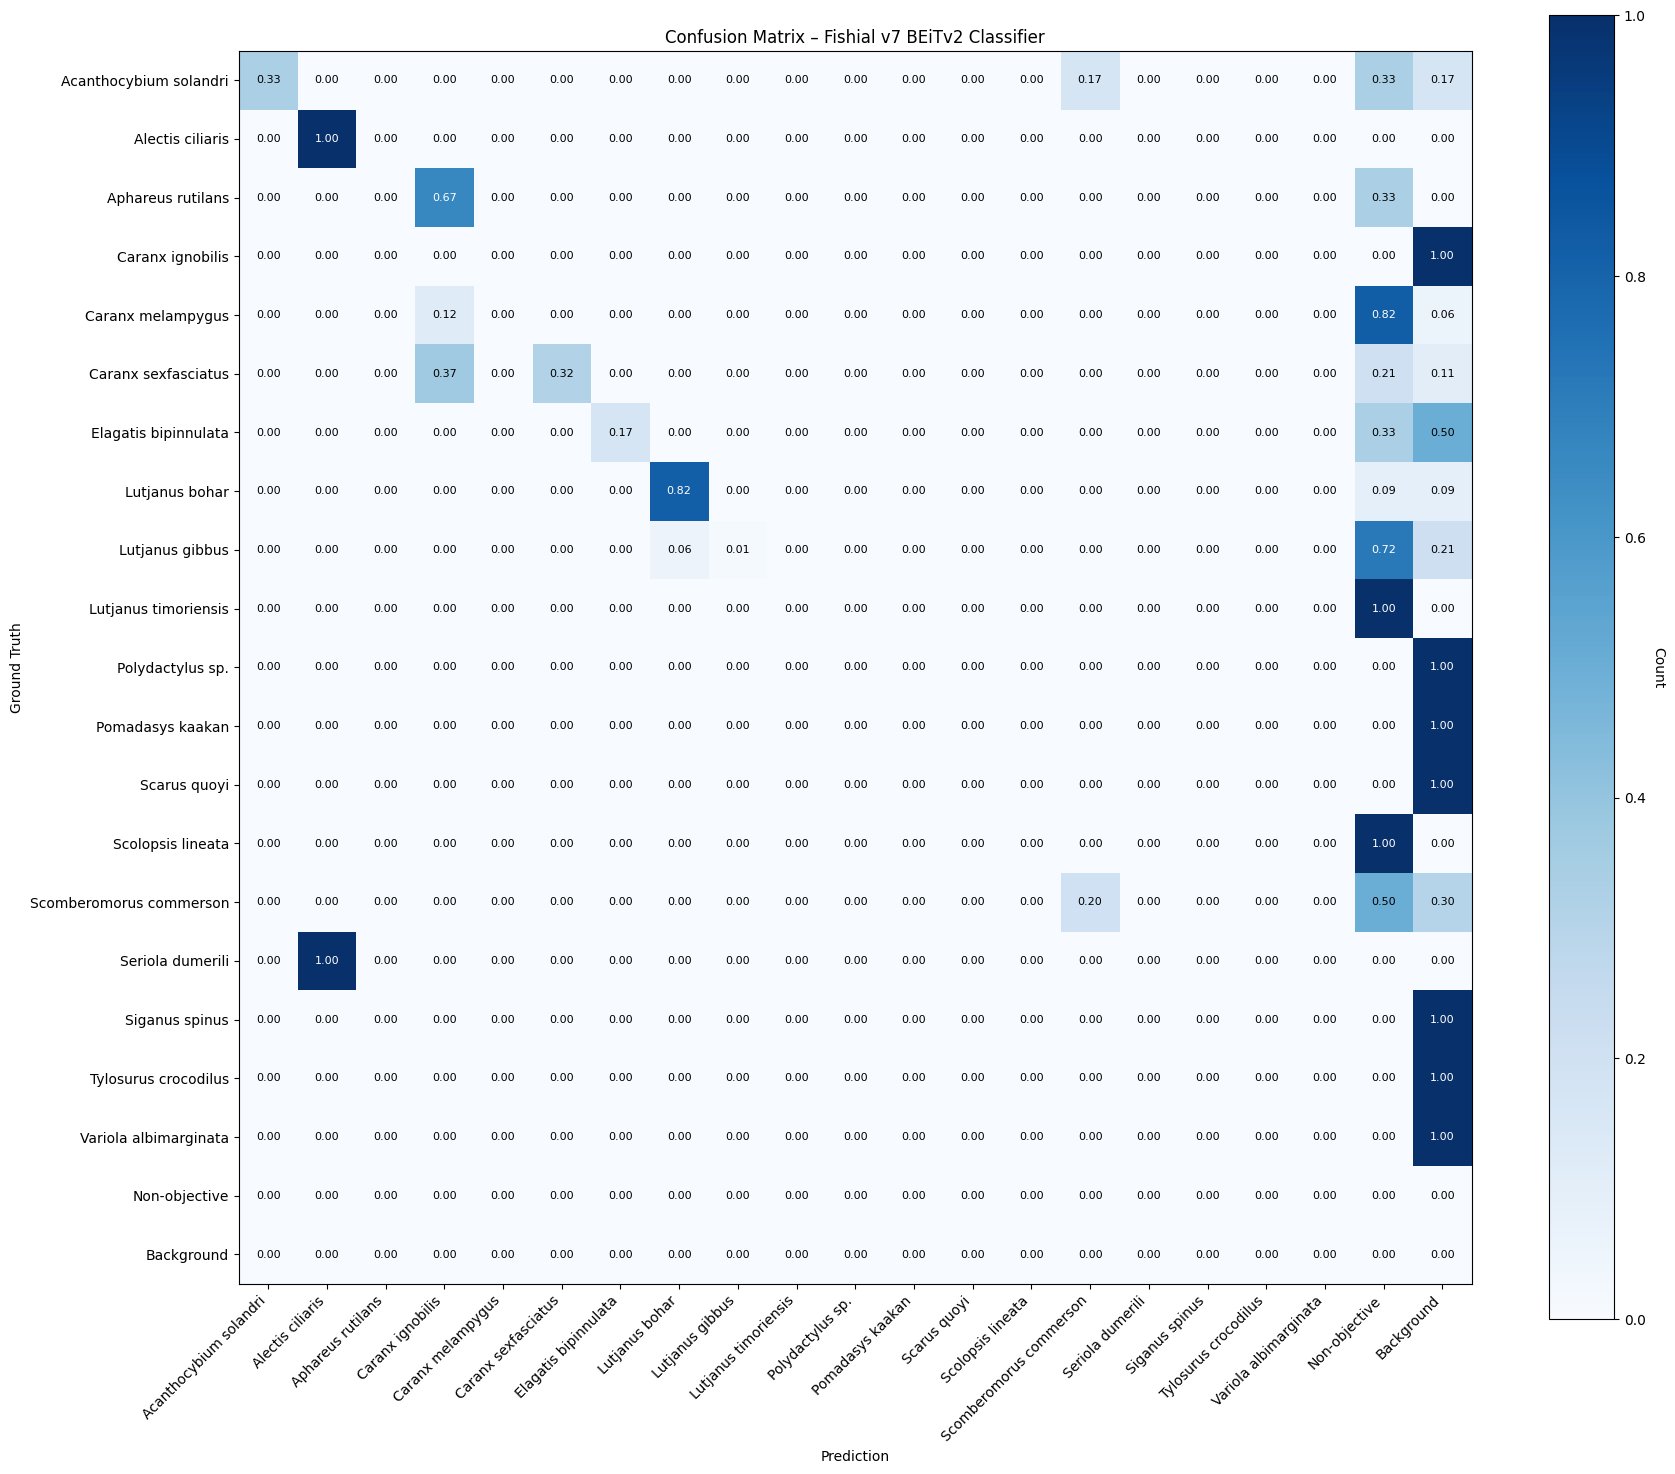

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load
df = pd.read_csv("results/298_classification.csv")
df.columns = [c.strip().lower() for c in df.columns]

# Handle NaN -> Background
df["ground_truth"] = df["ground_truth"].fillna("Background").astype(str)
df["prediction"]   = df["prediction"].fillna("Background").astype(str)

# ----------------------------------------------------
# 1) Use ONLY ground-truth species as real classes
# ----------------------------------------------------
gt_species = sorted(df["ground_truth"].unique())
if "Background" in gt_species:
    gt_species.remove("Background")

print("Ground truth species:", gt_species)

# ----------------------------------------------------
# 2) Map predictions:
#    - if in ground truth → keep
#    - if background → keep
#    - else → non-objective
# ----------------------------------------------------
def map_pred(p):
    if p == "Background":
        return "Background"
    elif p in gt_species:
        return p
    else:
        return "Non-objective"

df["prediction_mapped"] = df["prediction"].apply(map_pred)

# Map ground-truth: (only gt_species; anything else → background)
df["ground_truth_mapped"] = df["ground_truth"].apply(
    lambda x: x if x in gt_species else "background"
)

# ----------------------------------------------------
# 3) Final label order (ground truth species + non-objective + background)
# ----------------------------------------------------
unique_species = gt_species + ["Non-objective", "Background"]

print("Labels:", unique_species)

# Prepare arrays
y_true = df["ground_truth_mapped"].values
y_pred = df["prediction_mapped"].values

# ----------------------------------------------------
# 4) Compute confusion matrix
# ----------------------------------------------------
cm = confusion_matrix(y_true, y_pred, labels=unique_species, normalize="true")

# ----------------------------------------------------
# 5) Styled heatmap (your requested layout)
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 15))

# Heatmap
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# Tick labels
ax.set_xticks(np.arange(len(unique_species)))
ax.set_yticks(np.arange(len(unique_species)))
ax.set_xticklabels(unique_species)
ax.set_yticklabels(unique_species)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix – Fishial v7 BEiTv2 Classifier")

# Turn off grid
ax.grid(False)

# --- Add the values in each cell (no rounding, exact integers) ---
max_val = cm.max() if cm.max() > 0 else 1

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        text_color = "white" if val > max_val / 2 else "black"
        ax.text(
            j, i, f"{val:.2f}",  # exact integer
            ha="center", va="center",
            color=text_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()


# Bounding box detection

In [ ]:
# Where to save results
save_dir = "/content/FISHIAL_outputs"
os.makedirs(save_dir, exist_ok=True)
all_files = sorted(os.listdir(images_path))

In [ ]:
detection_results = []  # to store (filename, num_detections)

for img_path in file_names:
    try:
        print("\n" + "=" * 60)
        print(f"Processing: {os.path.basename(img_path)}")

        full_path = os.path.join(DATA_DIR, "timor_leste", img_path)
        fish_bgr_np = cv2.imread(full_path)
        if fish_bgr_np is None:
            print("Could not read image, skipping.")
            detection_results.append((os.path.basename(img_path), 0))
            continue

        visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
        visulize_img = visulize_img_rgb.copy()

        # OBJECT DETECTION (ONLY)
        boxes = detector.predict(visulize_img_rgb)[0]
        num_detections = len(boxes)

        # Save results
        detection_results.append((os.path.basename(img_path), num_detections))

        # Draw bounding boxes
        for box in boxes:
            box.draw_box(visulize_img)

        # Show + save visualization
        plt.figure()
        plt.imshow(visulize_img)
        plt.axis('off')
        plt.title(f"{os.path.basename(img_path)} ({num_detections} detections)")
        plt.show()

        vis_save_path = os.path.join(
            save_dir,
            f"{os.path.splitext(os.path.basename(img_path))[0]}_det.png"
        )
        cv2.imwrite(vis_save_path, cv2.cvtColor(visulize_img, cv2.COLOR_RGB2BGR))
        print(f"Saved visualization to: {vis_save_path}")

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        detection_results.append((os.path.basename(img_path), 0))


In [ ]:

df = pd.DataFrame(detection_results, columns=["filename", "num_detections"])
out_csv = os.path.join("/content/drive/MyDrive/FISHIAL", "298_detection.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print(f"\n Saved detection counts to {out_csv}")


 Saved detection counts to /content/drive/MyDrive/FISHIAL/detection_counts.csv


# Plots and statistics

## Detection

In [ ]:
df_det = pd.read_csv(os.path.join(DATA_DIR, "detection_results.csv"))
df_traits = pd.read_csv(os.path.join(DATA_DIR, "fish_traits.csv"), encoding="latin1")
df_counts = pd.read_csv(os.path.join(DATA_DIR, "detection_counts.csv"))

In [ ]:
df_det_unique = df_det.drop_duplicates(subset="filename", keep="first")

df_counts.drop(columns=["num_detections"], inplace=True)

merge = df_counts.merge(
    df_det_unique[["filename", "num_detections", "GT detections"]],
    on="filename",
    how="left"
)

print(merge.head())

            filename  num_detections  GT detections
0  1689120590238.jpg               1            7.0
1  1689577829534.jpg               0            5.0
2  1689577974563.jpg               1            1.0
3  1689594468820.jpg               2            3.0
4  1689651076768.jpg               1            1.0


In [ ]:
assert merge["filename"].tolist() == valid_rows["image_file"].tolist()

cols_to_add = ["num_detections", "GT detections"]

df_det_summary = pd.concat(
    [
        valid_rows.reset_index(drop=True),
        merge[cols_to_add].reset_index(drop=True)
    ],
    axis=1
)

In [ ]:
print(df_det_summary.head())

          image_file                                      catch_name_en  \
0  1689120590238.jpg                          Jacks/Trevally/Other Scad   
1  1689577829534.jpg                          Jacks/Trevally/Other Scad   
2  1689577974563.jpg  Jacks/Trevally/Other Scad & Jacks/Trevally/Oth...   
3  1689594468820.jpg  Emperor & Snapper/seaperch & Spinefoot & Surge...   
4  1689651076768.jpg                          Jacks/Trevally/Other Scad   

              Species_name      Family  num_detections  GT detections  
0      Caranx sexfasciatus  Carangidae               1            7.0  
1  Scomberomorus commerson  Scombridae               0            5.0  
2  Scomberomorus commerson  Scombridae               1            1.0  
3          Lutjanus gibbus  Lutjanidae               2            3.0  
4  Scomberomorus commerson  Scombridae               1            1.0  


In [ ]:
# Compare columns
same = df_det_summary["num_detections"] == df_det_summary["GT detections"]

# Count how many are alike
num_same = same.sum()
print(f"Images that were correctly detected: {num_same}/{len(df_det_summary)}")

# Species that worked (where they match)
worked = df_det_summary.loc[same, "Species_name"].unique().tolist()
print("\nSpecies that worked:")
print(worked)

# Species that did not work (where they differ)
failed = df_det_summary.loc[~same, "Species_name"].unique().tolist()
print("\nSpecies that did not work:")
print(failed)

Number of matching rows: 43/160

Species that worked:
['Scomberomorus commerson', 'Acanthocybium solandri', 'Caranx sexfasciatus', 'Lutjanus gibbus', 'Lutjanus bohar', 'Elagatis bipinnulata', 'Caranx melampygus']

Species that did not work:
['Caranx sexfasciatus', 'Scomberomorus commerson', 'Lutjanus gibbus', 'Caranx melampygus', 'Lutjanus bohar', 'Lutjanus fulviflamma', 'Elagatis bipinnulata', 'Seriola dumerili', 'Acanthocybium solandri', 'Tylosurus crocodilus', 'Caranx ignobilis', 'Alectis ciliaris', 'Lutjanus fulvus']


Total images counted: 160
Total represented in plot: 160 (should equal Total images)


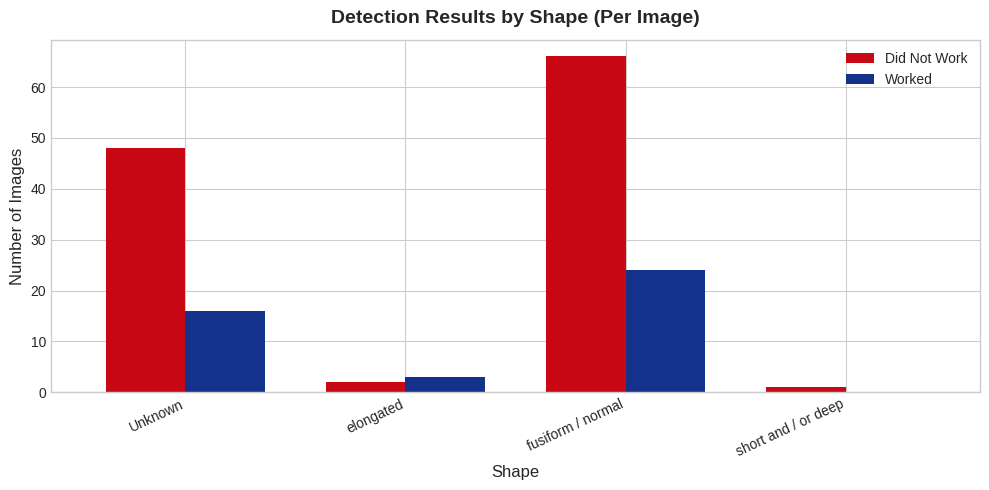

In [ ]:
#  Config
TRAIT_COLUMN = "shape"

# Normalize column names (lowercase for consistent joins)
df_det_summary.columns = [c.strip().lower() for c in df_det_summary.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_det_summary["worked"] = df_det_summary["num_detections"] == df_det_summary["gt detections"]

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_det_summary.merge(df_traits, on="species_name", how="left")

# If the chosen trait is missing, create it so nothing is dropped
if TRAIT_COLUMN not in df.columns:
    df[TRAIT_COLUMN] = "Unknown"

# Make sure trait has no NaNs so every row is counted
df[TRAIT_COLUMN] = df[TRAIT_COLUMN].fillna("Unknown")

# Sanity check: this should be your total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-trait x worked counts (counts rows/images)
summary = df.groupby([TRAIT_COLUMN, "worked"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]

summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title(f"Detection Results by {TRAIT_COLUMN.capitalize()} (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel(TRAIT_COLUMN.capitalize(), fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Total images counted: 160
Total represented in plot: 160 (should equal Total images)


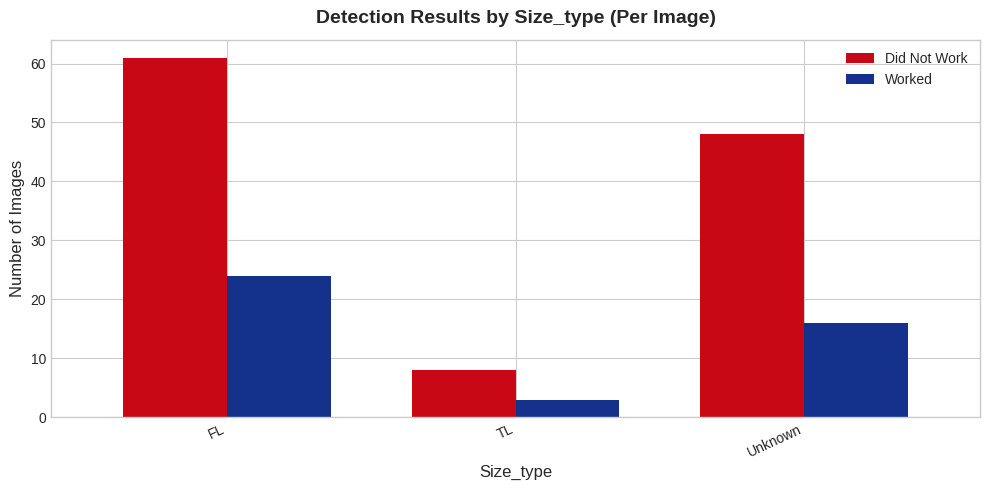

In [ ]:
#  Config
TRAIT_COLUMN = "size_type"

# Normalize column names (lowercase for consistent joins)
df_det_summary.columns = [c.strip().lower() for c in df_det_summary.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_det_summary["worked"] = df_det_summary["num_detections"] == df_det_summary["gt detections"]

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_det_summary.merge(df_traits, on="species_name", how="left")

# If the chosen trait is missing, create it so nothing is dropped
if TRAIT_COLUMN not in df.columns:
    df[TRAIT_COLUMN] = "Unknown"

# Make sure trait has no NaNs so every row is counted
df[TRAIT_COLUMN] = df[TRAIT_COLUMN].fillna("Unknown")

# Sanity check: this should be your total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-trait x worked counts (counts rows/images)
summary = df.groupby([TRAIT_COLUMN, "worked"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]

summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title(f"Detection Results by {TRAIT_COLUMN.capitalize()} (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel(TRAIT_COLUMN.capitalize(), fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


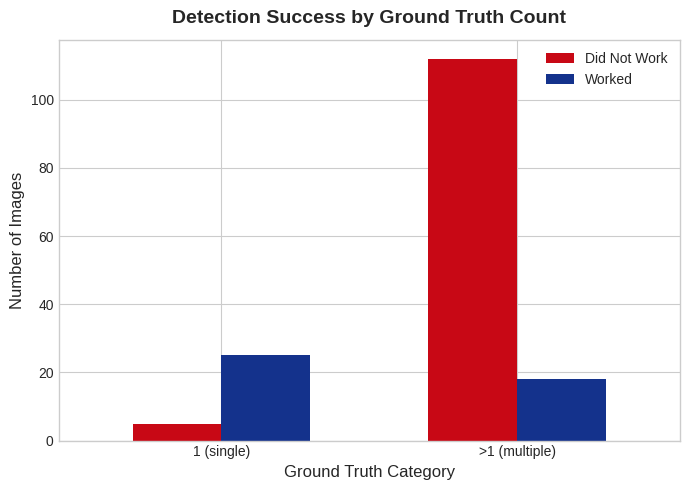

In [ ]:

df = df_det_summary.copy()

# --- Compute whether it worked (detections match) ---
df["worked"] = df["num_detections"] == df["gt detections"]

# --- Create a new column grouping ground truth counts ---
df["gt_group"] = df["gt detections"].apply(lambda x: "1 (single)" if x == 1 else ">1 (multiple)")

# --- Count worked vs not worked for each group ---
summary = df.groupby(["gt_group", "worked"]).size().unstack(fill_value=0)

# --- Plot with neutral colors ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(7, 5))

colors = ["#c80815", "#14328C"]
summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    color=colors,
    ax=ax,
    width=0.6,
    edgecolor="none"
)

ax.set_title("Detection Success by Ground Truth Count", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Ground Truth Category", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


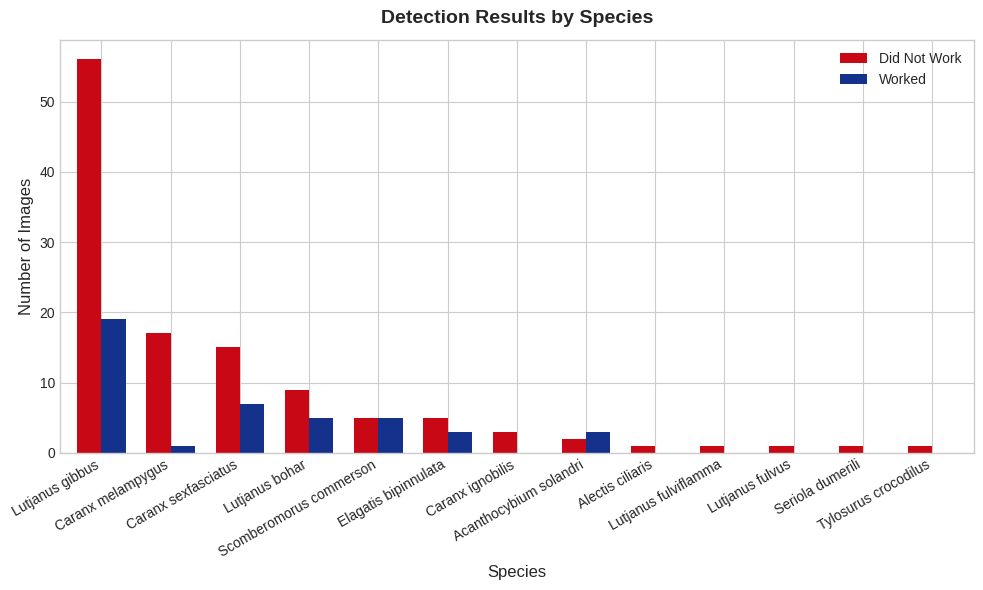

In [ ]:

# Compute whether it worked (detections match)
df["worked"] = df["num_detections"] == df["gt detections"]

# Group by species and count worked vs not worked
summary = df.groupby(["species_name", "worked"]).size().unstack(fill_value=0)

# Sort by total count for nicer ordering
summary = summary.sort_values(by=summary.columns.tolist(), ascending=False)

# Plot with neutral colors
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#c80815", "#14328C"]
summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.7,
    edgecolor="none",
    ax=ax
)

ax.set_title("Detection Results by Species", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Species", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


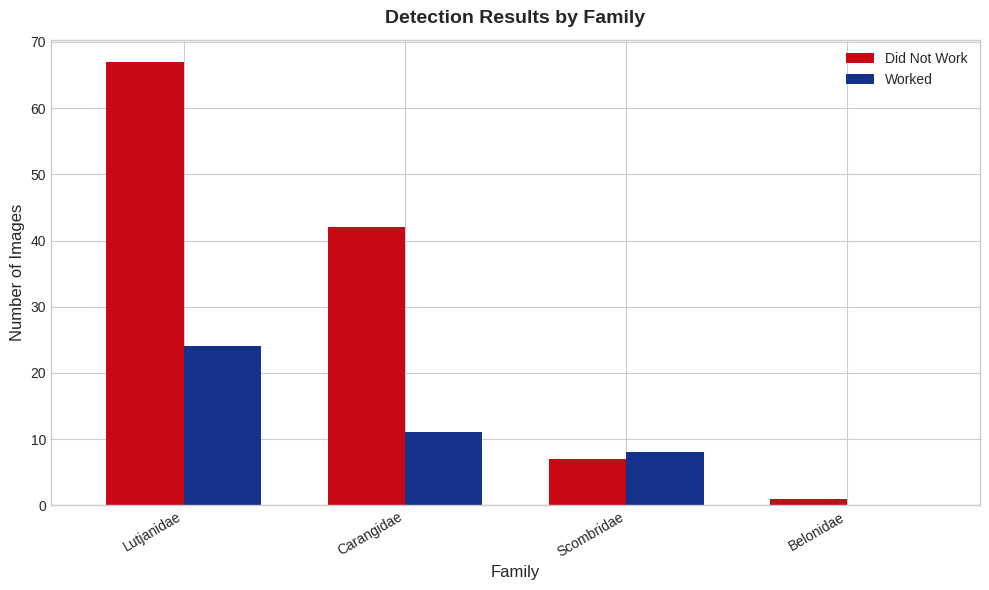

In [ ]:

# Compute whether it worked (detections match)
df["worked"] = df["num_detections"] == df["gt detections"]

# Group by species and count worked vs not worked
summary = df.groupby(["family", "worked"]).size().unstack(fill_value=0)

# Sort by total count for nicer ordering
summary = summary.sort_values(by=summary.columns.tolist(), ascending=False)

# Plot with neutral colors
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#c80815", "#14328C"]
summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.7,
    edgecolor="none",
    ax=ax
)

ax.set_title("Detection Results by Family", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Family", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Total images counted: 160
Total represented in plot: 160 (should equal Total images)


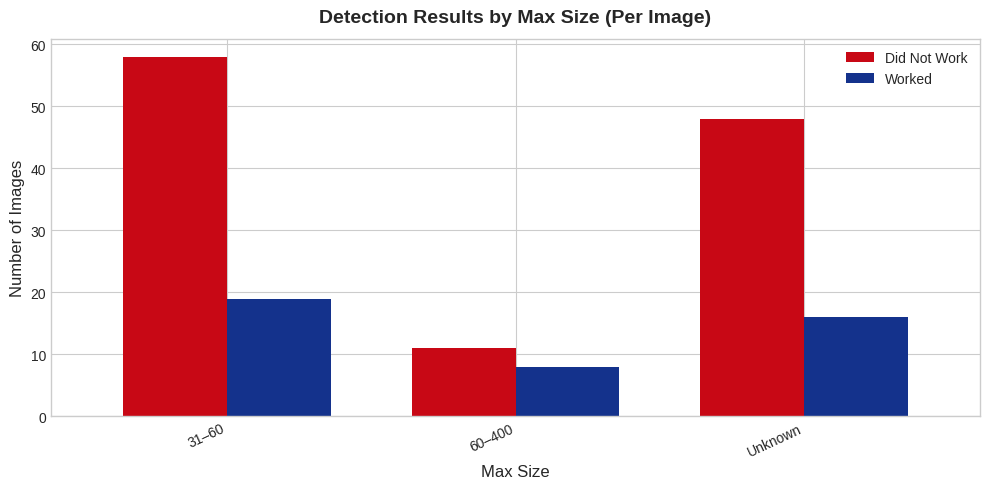

In [ ]:
MAX_SIZE_COL = "max_size"
BIN_METHOD = "quantile"
N_BINS = 3
FIXED_BINS = None

# Normalize column names (lowercase for consistent joins)
df_det_summary.columns = [c.strip().lower() for c in df_det_summary.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_det_summary["worked"] = df_det_summary["num_detections"] == df_det_summary["gt detections"]

# Ensure max_size is numeric in traits
if MAX_SIZE_COL not in df_traits.columns:
    raise ValueError(f"Column '{MAX_SIZE_COL}' not found in traits file.")
df_traits[MAX_SIZE_COL] = pd.to_numeric(df_traits[MAX_SIZE_COL], errors="coerce")

# Build size bins on the traits table (by species)
size_series = df_traits[MAX_SIZE_COL].dropna()
if BIN_METHOD == "quantile":
    # Create quantile bins with readable labels
    # Drop duplicate edges if data has ties
    q = np.linspace(0, 1, N_BINS + 1)
    edges = np.unique(np.quantile(size_series, q))
    # If not enough unique edges (too many duplicates), fall back to fixed-width
    if len(edges) < 3:
        BIN_METHOD = "fixed"
        FIXED_BINS = np.linspace(size_series.min(), size_series.max(), min(N_BINS, 6) + 1)
    else:
        bins = edges
elif BIN_METHOD == "fixed":
    if FIXED_BINS is None:
        # Default fixed bins spanning the observed range (6 bins)
        bins = np.linspace(size_series.min(), size_series.max(), 7)
    else:
        bins = FIXED_BINS
else:
    raise ValueError("BIN_METHOD must be 'quantile' or 'fixed'.")

# Finalize bins
if BIN_METHOD == "fixed":
    bins = np.asarray(bins, dtype=float)

# Create binned labels on traits
if len(size_series) == 0:
    df_traits["max_size_bin"] = "Unknown"
else:
    def make_labels(edges):
        labels = []
        for a, b in zip(edges[:-1], edges[1:]):
            if np.isinf(b):
                labels.append(f"{int(round(a))}+" )
            else:
                labels.append(f"{int(round(a))}–{int(round(b))}")
        return labels

    labels = make_labels(bins)
    df_traits["max_size_bin"] = pd.cut(
        df_traits[MAX_SIZE_COL],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    ).astype(object)

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_det_summary.merge(df_traits[["species_name", "max_size_bin"]], on="species_name", how="left")

# Make sure trait has no NaNs so every row is counted
df["max_size_bin"] = df["max_size_bin"].fillna("Unknown")

# Sanity check: this should be the total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-size-bin x worked counts (counts rows/images)
summary = df.groupby(["max_size_bin", "worked"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]  # red = Did Not Work, blue = Worked
summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Detection Results by Max Size (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Max Size", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Classification

In [ ]:
df_class = pd.read_csv(os.path.join(DATA_DIR, "evaluation_results_classification.csv"))
df_traits = pd.read_csv(os.path.join(DATA_DIR, "fish_traits.csv"), encoding="latin1")
df_tl_ann = pd.read_csv(os.path.join(DATA_DIR, "timor-leste.csv"))

In [ ]:
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Extract arrays
matched = df_class.loc[df_class["status"] == "MATCH", "filename"].tolist()
mismatched = df_class.loc[df_class["status"] == "MISMATCH", "filename"].tolist()

print("Number of matches:", len(matched))
print("Number of mismatches:", len(mismatched))


Number of matches: 22
Number of mismatches: 138


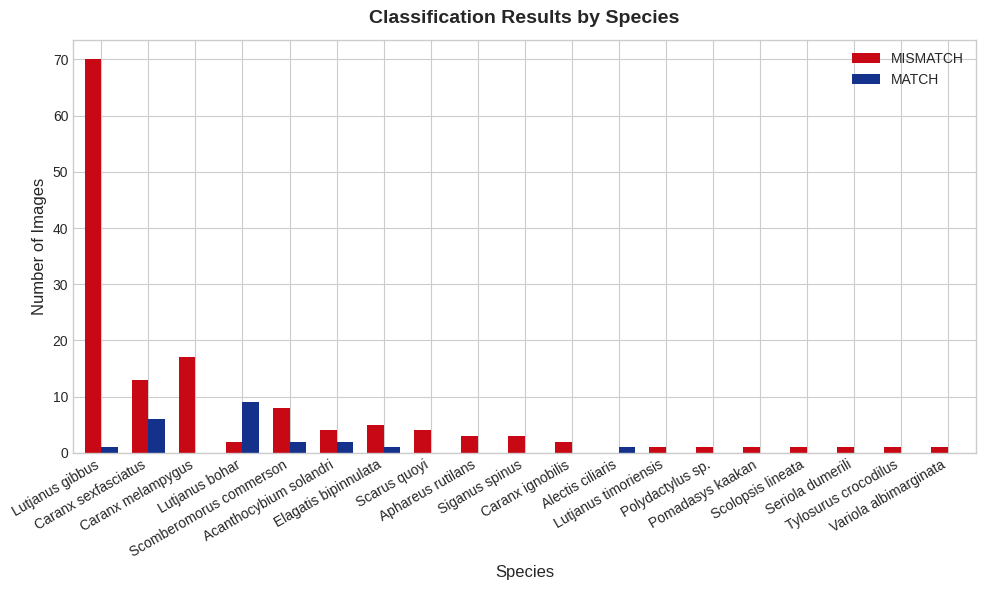

In [ ]:
# Config
GROUP_BY = "ground_truth"

# Determine match status
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Summarize
summary = df_class.groupby([GROUP_BY, "status"]).size().unstack(fill_value=0)

# Sort by total count
summary = summary.loc[summary.sum(axis=1).sort_values(ascending=False).index]

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#c80815", "#14328C"]  # red for MISMATCH, blue for MATCH
summary = summary[["MISMATCH", "MATCH"]]

summary.plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.7,
    edgecolor="none",
    figsize=(10,6)
)

plt.title(f"Classification Results by Species", fontsize=14, weight="semibold", pad=12)
plt.xlabel("Species", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.legend(frameon=False)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Total images counted: 160
Total represented in plot: 160 (should equal Total images)


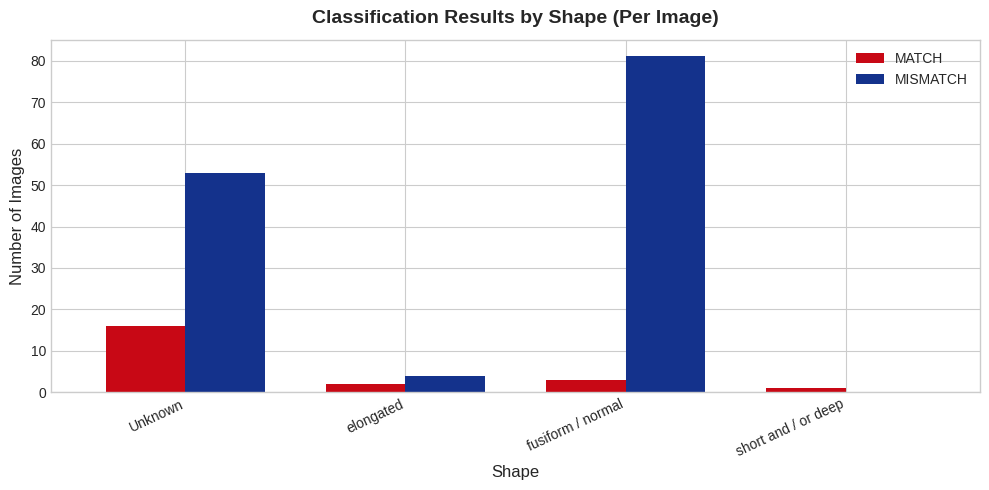

In [ ]:
#  Config
TRAIT_COLUMN = "shape"

# Normalize column names (lowercase for consistent joins)
df_class.columns = [c.strip().lower() for c in df_class.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_class.merge(df_traits, left_on="ground_truth", right_on="species_name", how="left")

# If the chosen trait is missing, create it so nothing is dropped
if TRAIT_COLUMN not in df.columns:
    df[TRAIT_COLUMN] = "Unknown"

# Make sure trait has no NaNs so every row is counted
df[TRAIT_COLUMN] = df[TRAIT_COLUMN].fillna("Unknown")

# Sanity check: this should be your total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-trait x worked counts (counts rows/images)
summary = df.groupby([TRAIT_COLUMN, "status"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]

summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title(f"Classification Results by {TRAIT_COLUMN.capitalize()} (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel(TRAIT_COLUMN.capitalize(), fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Rows after merge: 160


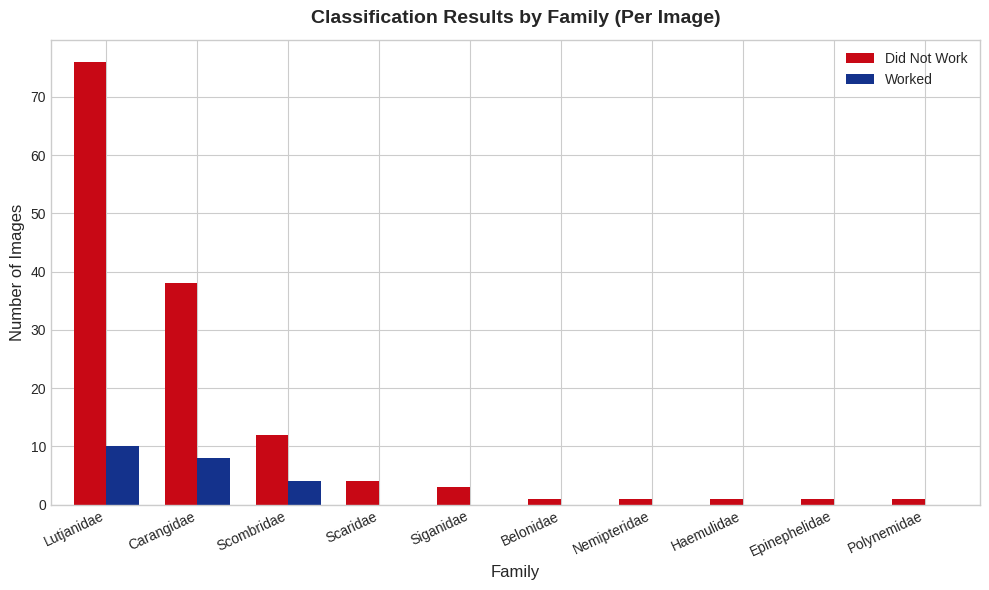

In [ ]:
SPECIES_COL_CSV = "Species_name"
FAMILY_COL_CSV = "Family"

# 1) Compute MATCH / MISMATCH
df_class["status"] = (df_class["prediction"] == df_class["ground_truth"])

# Normalize names
def _norm(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower()

df_class["_gt_norm"] = _norm(df_class["ground_truth"])
df_tl_ann["_species_norm"] = _norm(df_tl_ann[SPECIES_COL_CSV])

# Drop duplicates so one species only maps to one Family
df_tl_ann_unique = df_tl_ann.drop_duplicates(subset="_species_norm", keep="first")

# 2) Merge to get Family for each image
df_all = df_class.merge(
    df_tl_ann_unique[["_species_norm", FAMILY_COL_CSV]],
    left_on="_gt_norm",
    right_on="_species_norm",
    how="left"
)
df_all[FAMILY_COL_CSV] = df_all[FAMILY_COL_CSV].fillna("Unknown")

print("Rows after merge:", len(df_all))  # should be equal to len(df_class)

# 3) Group and count by Family + status
summary = df_all.groupby([FAMILY_COL_CSV, "status"]).size().unstack(fill_value=0)
summary = summary.loc[summary.sum(axis=1).sort_values(ascending=False).index]

# 4) Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#c80815", "#14328C"]  # red = mismatch, blue = match

summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Classification Results by Family (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Family", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Total images counted: 160
Total represented in plot: 160 (should equal Total images)


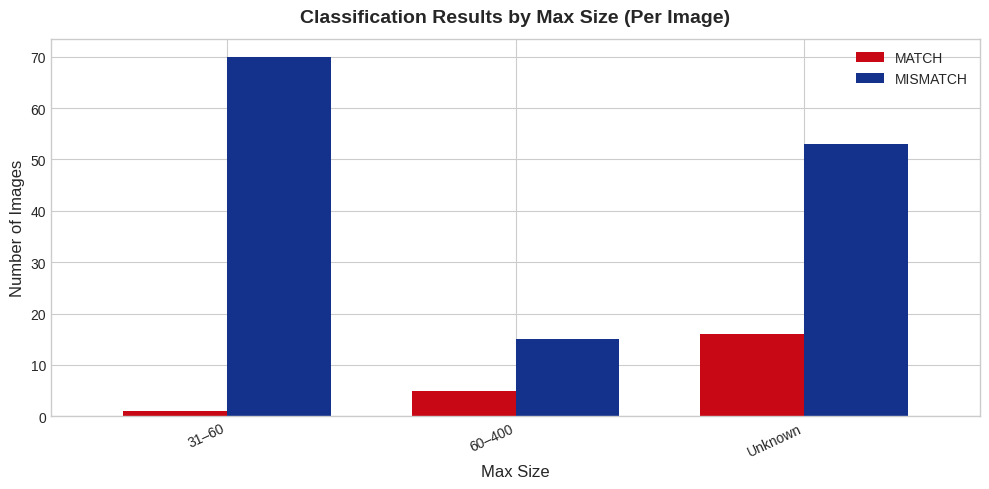

In [ ]:
MAX_SIZE_COL = "max_size"
BIN_METHOD = "quantile"
N_BINS = 3
FIXED_BINS = None

# Normalize column names (lowercase for consistent joins)
df_class.columns = [c.strip().lower() for c in df_class.columns]
df_traits.columns = [c.strip().lower() for c in df_traits.columns]

# Compute worked per image (row)
df_class["status"] = df_class.apply(
    lambda row: "MATCH" if row["prediction"] == row["ground_truth"] else "MISMATCH",
    axis=1
)

# Ensure max_size is numeric in traits
if MAX_SIZE_COL not in df_traits.columns:
    raise ValueError(f"Column '{MAX_SIZE_COL}' not found in traits file.")
df_traits[MAX_SIZE_COL] = pd.to_numeric(df_traits[MAX_SIZE_COL], errors="coerce")

# Build size bins on the traits table (by species)
size_series = df_traits[MAX_SIZE_COL].dropna()
if BIN_METHOD == "quantile":
    # Create quantile bins with readable labels
    # Drop duplicate edges if data has ties
    q = np.linspace(0, 1, N_BINS + 1)
    edges = np.unique(np.quantile(size_series, q))
    # If not enough unique edges (too many duplicates), fall back to fixed-width
    if len(edges) < 3:
        BIN_METHOD = "fixed"
        FIXED_BINS = np.linspace(size_series.min(), size_series.max(), min(N_BINS, 6) + 1)
    else:
        bins = edges
elif BIN_METHOD == "fixed":
    if FIXED_BINS is None:
        # Default fixed bins spanning the observed range (6 bins)
        bins = np.linspace(size_series.min(), size_series.max(), 7)
    else:
        bins = FIXED_BINS
else:
    raise ValueError("BIN_METHOD must be 'quantile' or 'fixed'.")

# Finalize bins
if BIN_METHOD == "fixed":
    bins = np.asarray(bins, dtype=float)

# Create binned labels on traits
if len(size_series) == 0:
    df_traits["max_size_bin"] = "Unknown"
else:
    def make_labels(edges):
        labels = []
        for a, b in zip(edges[:-1], edges[1:]):
            if np.isinf(b):
                labels.append(f"{int(round(a))}+" )
            else:
                labels.append(f"{int(round(a))}–{int(round(b))}")
        return labels

    labels = make_labels(bins)
    df_traits["max_size_bin"] = pd.cut(
        df_traits[MAX_SIZE_COL],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    ).astype(object)

# Merge PER-ROW with traits on species_name (keeps all images)
df = df_class.merge(df_traits[["species_name", "max_size_bin"]], left_on="ground_truth", right_on="species_name", how="left")

# Make sure trait has no NaNs so every row is counted
df["max_size_bin"] = df["max_size_bin"].fillna("Unknown")

# Sanity check: this should be the total image count
total_images = len(df)
print(f"Total images counted: {total_images}")

# Build per-size-bin x worked counts (counts rows/images)
summary = df.groupby(["max_size_bin", "status"]).size().unstack(fill_value=0)

# Verify nothing was lost
counted_total = summary.values.sum()
print(f"Total represented in plot: {counted_total} (should equal Total images)")

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#c80815", "#14328C"]  # red = Did Not Work, blue = Worked
summary.rename(columns={False: "Did Not Work", True: "Worked"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Classification Results by Max Size (Per Image)", fontsize=14, weight="semibold", pad=12)
ax.set_xlabel("Max Size", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


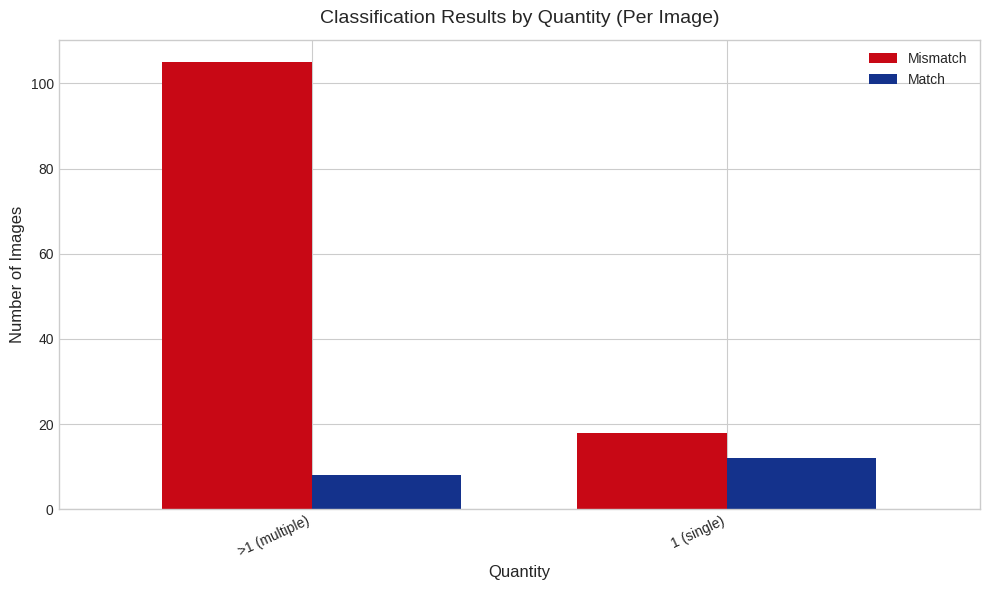

In [ ]:

df_class.columns = [c.strip().lower() for c in df_class.columns]
df_det_summary.columns = [c.strip().lower() for c in df_det_summary.columns]

# Use boolean so the plotting rename({False:"Did Not Work", True:"Worked"}) works
df_class["status"] = df_class["prediction"] == df_class["ground_truth"]

# If df_class contains multiple rows per filename, collapse to one.
# Strategy: if duplicates exist, keep the last (you can switch to 'first' if preferred).
df_class_unique = df_class.drop_duplicates(subset="filename", keep="last")

GT_COL = "gt detections"
if GT_COL not in df_det_summary.columns:
    raise KeyError(f"df_det_summary must have '{GT_COL}' column.")

# Coerce to int (non-numeric -> 0)
df_det_summary[GT_COL] = (
    pd.to_numeric(df_det_summary[GT_COL], errors="coerce")
      .fillna(0)
      .astype(int)
)

# Bucket: 1 vs >1
df_det_summary["gt_group"] = np.where(
    df_det_summary[GT_COL] == 1, "1 (single)",
    np.where(df_det_summary[GT_COL] > 1, ">1 (multiple)", "0 (none)")
)

# If df_det_summary contains multiple rows per image_file, deduplicate.
# Pick the "largest" gt detections for that image to be safe (or use 'first' if you prefer).
agg = (
    df_det_summary
    .sort_values([GT_COL], ascending=False)
    .drop_duplicates(subset="image_file", keep="first")
)

merge = df_class_unique.merge(
    agg[["image_file", "gt_group"]],
    left_on="filename",
    right_on="image_file",
    how="left"
)

# Anything not found -> Unknown bucket
merge["gt_group"] = merge["gt_group"].fillna("Unknown")

summary = (
    merge.groupby(["gt_group", "status"])
         .size()
         .unstack(fill_value=0)
)

# Sort by total count for nicer order
summary = summary.loc[summary.sum(axis=1).sort_values(ascending=False).index]


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#c80815", "#14328C"]  # [False, True] -> red mismatch, blue match

summary.rename(columns={False: "Mismatch", True: "Match"}).plot(
    kind="bar",
    stacked=False,
    color=colors,
    width=0.72,
    edgecolor="none",
    ax=ax
)

ax.set_title("Classification Results by Quantity (Per Image)", fontsize=14, pad=12)
ax.set_xlabel("Quantity", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.legend(frameon=False)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

